In [1]:
import nltk

# nltk.download('stopwords')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [3]:
# Gensim (Topic Modeling Pacakge)
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [4]:
# spacy for lemmatization
import spacy

from spacy_download import load_spacy

In [5]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [7]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [8]:
'''
We will be using the 20-Newsgroups dataset for this exercise.
This version of the dataset contains about 11k newsgroups posts from 
20 different topics. This is available as newsgroups.json.
'''
# Import Dataset
df = pd.read_csv('disinformation_2ndclean(sm).csv')
print(df.Title.unique())
df.head()


['India Is In The Middle Of A Coronavirus YouTube Frenzy, And It’s Going To Get People Killed'
 'Tweet: False reporting on "shooting down" people with the virus in China'
 'Tweet: A woman eating a delicacy, attributing the virus to eating "bat soup"'
 ...
 'Fact Check: There Are Currently NO Vaccines Available For COVID-19 In the U.S.'
 "Fact Check: COVID-19 Is NOT 'The Most Highly Survivable Virus'"
 'Report as if Japanese scientist speaks about manufactured coronavirus is fake']


,Reported_On,Additional_Reporting,Retrieve_from_1,Retrieve_from_2,Retrieve_from_3,Twitter_Reference,Direct_Post_1,Direct_Post_2,Direct_Post_3,Direct_Post_4,...,Narrative_Description,ChainMsg_or_Email,Motive,Motive_Description,Source,Source_Description,Distrib_Channel,Misinfo_Type,Key_Words,Summary
0,https://www.buzzfeednews.com/article/ryanhates...,NaN,https://www.buzzfeednews.com/article/ryanhates...,NaN,NaN,False,NaN,NaN,NaN,NaN,...,Hindi language YouTube account saying COVID-19...,False,Politics,Efforts to spread false claims on the origins ...,Individual actor,General public,Youtube,Conspiracy,"Coronavirus, India, bat soup",Hindi language Youtube account suggesting COVI...
1,https://twitter.com/Rangoli_A/status/122779241...,NaN,NaN,NaN,NaN,True,https://twitter.com/Rangoli_A/status/122779241...,NaN,NaN,NaN,...,Twitter user posting a compilation video of pe...,False,Fear,"Twitter user stoking fear among other users, s...",Individual actor,General public,Twitter,False reporting,"Coronavirus, China, shooting","Tweet with video showing ""people getting shot ..."
2,https://twitter.com/Woppa1Woppa/status/1220068...,NaN,NaN,NaN,NaN,True,https://twitter.com/Woppa1Woppa/status/1220068...,NaN,NaN,NaN,...,Twitter user posting a video of a celebrity ea...,False,Politics,Twitter user discrediting Chinese-American pop...,Individual actor,General public,Twitter,False reporting,"Coronavirus, Chinese food, bat soup","Video of an individual eating a delicacy, and ..."
3,https://twitter.com/FreddiGoldstein/status/123...,NaN,NaN,NaN,NaN,True,https://twitter.com/FreddiGoldstein/status/123...,NaN,NaN,NaN,...,Chain message of NYPD containment responses.,True,Fear,Chain message spread to stoke fear among Ameri...,Individual actor,General public,Twitter,False reporting,"Coronavirus, NYPD, containment zone",Tweet with a screenshot of chain message sugge...
4,https://www.boomlive.in/health/hoax-alert-vira...,NaN,https://www.boomlive.in/health/hoax-alert-vira...,NaN,NaN,False,NaN,NaN,NaN,NaN,...,Chain message of Indian Health Ministry respon...,True,Fear,Chain message spread to stoke fear among India...,Individual actor,General public,Facebook,False reporting,"Coronavirus, India, travel advisory",WhatsApp chain message circulating among India...


In [9]:
df.Summary

0       Hindi language Youtube account suggesting COVI...
1       Tweet with video showing "people getting shot ...
2       Video of an individual eating a delicacy, and ...
3       Tweet with a screenshot of chain message sugge...
4       WhatsApp chain message circulating among India...
                              ...                        
1264    A meme on Facebook claims new data from CDC sh...
1265    A meme on Facebook claims South Carolina issue...
1266    A Facebook post claims a doctor told her there...
1267    A Facebook post claims COVID-19 is the most hi...
1268    Report claims that Japanese Professor Tasuku H...
Name: Summary, Length: 1269, dtype: object

In [10]:
df.count()

Reported_On               1269
Additional_Reporting        68
Retrieve_from_1            529
Retrieve_from_2            104
Retrieve_from_3             37
Twitter_Reference         1269
Direct_Post_1              632
Direct_Post_2              275
Direct_Post_3              153
Direct_Post_4              111
Title                     1266
Publication_Date          1269
Primary_Country           1269
Secondary_Country          105
Primary_Language          1269
Main_Narrative            1269
Recoded_Main_Narrative     568
Narrative_Description     1269
ChainMsg_or_Email         1269
Motive                    1269
Motive_Description        1269
Source                    1269
Source_Description        1269
Distrib_Channel           1269
Misinfo_Type              1269
Key_Words                 1269
Summary                   1269
dtype: int64

In [11]:
'''
As you can see there are many emails, newline and extra spaces that is quite distracting.
Let’s get rid of them using regular expressions.
'''
# Convert to list
data = df.Title.tolist()


pprint(data[:1])

['India Is In The Middle Of A Coronavirus YouTube Frenzy, And It’s Going To '
 'Get People Killed']


In [12]:

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['india', 'is', 'in', 'the', 'middle', 'of', 'coronavirus', 'youtube', 'frenzy', 'and', 'it', 'going', 'to', 'get', 'people', 'killed']]


In [13]:

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['india', 'is', 'in', 'the', 'middle', 'of', 'coronavirus', 'youtube', 'frenzy', 'and', 'it', 'going', 'to', 'get', 'people', 'killed']


In [14]:

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Will download the model if it isn't installed yet 
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



print(data_lemmatized[:1])

[['youtube', 'frenzy', 'go', 'get', 'people', 'kill']]


In [16]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [17]:
vocab = len(id2word.token2id)

pd.Series([t for tokens in data_words_bigrams for t in tokens if "_" in t]).unique()

array(['fact_check', 'conspiracy_theory', 'bill_gates', 'social_media',
       'south_africa', 'health_organization', 'face_masks',
       'donald_trump', 'tested_positive', 'south_african', 'new_york',
       'social_distancing', 'cek_fakta', 'clarifications_regarding',
       'anthony_fauci', 'covid__'], dtype=object)

In [18]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]



[(0,
  '0.058*"pandemic" + 0.046*"cause" + 0.042*"cure" + 0.035*"home" + '
  '0.024*"pay" + 0.021*"bill" + 0.020*"conspiracy" + 0.015*"test" + '
  '0.013*"blue" + 0.013*"tested_positive"'),
 (1,
  '0.223*"covid" + 0.068*"false" + 0.049*"claim" + 0.039*"mask" + 0.037*"say" '
  '+ 0.023*"post" + 0.014*"evidence" + 0.013*"new" + 0.013*"trump" + '
  '0.012*"case"'),
 (2,
  '0.213*"vaccine" + 0.034*"government" + 0.020*"pfizer" + '
  '0.019*"donald_trump" + 0.019*"state" + 0.016*"work" + 0.014*"coronaviru" + '
  '0.013*"develop" + 0.010*"fraud" + 0.010*"turn"'),
 (3,
  '0.067*"coronavirus" + 0.039*"test" + 0.023*"make" + 0.023*"viral" + '
  '0.021*"take" + 0.019*"get" + 0.018*"doctor" + 0.018*"facebook" + '
  '0.016*"news" + 0.015*"stop"'),
 (4,
  '0.044*"photo" + 0.029*"old" + 0.028*"wrong" + 0.027*"flu" + '
  '0.026*"lockdown" + 0.025*"rate" + 0.024*"image" + 0.020*"bill_gate" + '
  '0.019*"video" + 0.018*"disease"'),
 (5,
  '0.102*"people" + 0.038*"share" + 0.036*"kill" + 0.035*"fact_che

In [20]:
'''
Model perplexity and topic coherence provide a convenient measure to judge 
how good a given topic model is. In my experience, topic coherence score, 
in particular, has been more helpful.
'''
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)




Perplexity:  -7.5359243016393265

Coherence Score:  0.5745818333199714


In [21]:
'''
Now that the LDA model is built, the next step is to examine the produced 
topics and the associated keywords. There is no better tool than pyLDAvis package’s 
interactive chart and is designed to work well with jupyter notebooks.
'''
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\hannah.kim\AppData\Roaming\Python\Python39\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.355468  0.153990       1        1  27.871359
3     -0.133368 -0.318117       2        1  18.789227
9      0.089325  0.043619       3        1   9.228582
4      0.089303  0.007957       4        1   8.949883
7      0.055171  0.012676       5        1   7.257203
5      0.065154  0.049344       6        1   7.108854
0      0.025824 -0.025667       7        1   7.092348
2      0.063037  0.045317       8        1   6.063185
8      0.054835  0.019734       9        1   4.507766
6      0.046187  0.011148      10        1   3.131594, topic_info=             Term        Freq       Total Category  logprob  loglift
45          covid  499.000000  499.000000  Default  30.0000  30.0000
78        vaccine  101.000000  101.000000  Default  29.0000  29.0000
6           false  148.000000  148.000000  Default  28.0000  28.0000
294         death   62.000000   62.000000  Default  27.0000  27.0000
22    coronavirus  100.000000  100.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
2018     claiming    1.283164    1.975123  Topic10  -5.2516   3.0323
1987        clean    1.278779    1.971583  Topic10  -5.2550   3.0307
1988      grocery    1.278779    1.971583  Topic10  -5.2550   3.0307
805           ask    1.265559    1.956273  Topic10  -5.2654   3.0281
768    foundation    1.183663    1.874416  Topic10  -5.3323   3.0039

[350 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2087      9  0.940374      aarp
2114      5  0.734699   aborted
163       6  0.949136   account
1383      9  0.839816  actually
407       4  0.912206       add
...     ...       ...       ...
779       6  0.962967     world
1390      4  0.942987     wrong
733       8  0.866248   wrongly
437       3  0.967768      year
436       5  0.817588       yet

[325 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 10, 5, 8, 6, 1, 3, 9, 7])

In [22]:
output = lda_model.show_topics(num_words=30)

In [23]:
output_df = pd.DataFrame()
for o in output:    
    d = {}
    topic_num = o[0]
    distribution = o[1]
    decimal_list = re.findall(r'\d+\.\d+', distribution)
    word_list = re.findall(r'"([^"]*)"', distribution)
    d["topic_" + str(topic_num + 1) + "_word"] = word_list
    d["topic_" + str(topic_num + 1) + "_dist"] =  decimal_list

    topic_df = pd.DataFrame(d)
    output_df = pd.concat([output_df, topic_df], axis=1)

output_df

,topic_1_word,topic_1_dist,topic_2_word,topic_2_dist,topic_3_word,topic_3_dist,topic_4_word,topic_4_dist,topic_5_word,topic_5_dist,topic_6_word,topic_6_dist,topic_7_word,topic_7_dist,topic_8_word,topic_8_dist,topic_9_word,topic_9_dist,topic_10_word,topic_10_dist
0,pandemic,0.058,covid,0.223,vaccine,0.213,coronavirus,0.067,photo,0.044,people,0.102,due,0.046,death,0.108,die,0.101,video,0.056
1,cause,0.046,false,0.068,government,0.034,test,0.039,old,0.029,share,0.038,fund,0.034,fake,0.085,research,0.028,report,0.046
2,cure,0.042,claim,0.049,pfizer,0.020,make,0.023,wrong,0.028,kill,0.036,food,0.027,spread,0.050,offer,0.026,show,0.044
3,home,0.035,mask,0.039,donald_trump,0.019,viral,0.023,flu,0.027,fact_check,0.035,call,0.019,misinformation,0.020,infect,0.021,virus,0.043
4,pay,0.024,say,0.037,state,0.019,take,0.021,lockdown,0.026,number,0.028,gate,0.018,plan,0.019,free,0.019,receive,0.022
5,bill,0.021,post,0.023,work,0.016,get,0.019,rate,0.025,give,0.023,arrest,0.016,confirm,0.018,cancer,0.017,year,0.022
6,conspiracy,0.020,evidence,0.014,coronaviru,0.014,doctor,0.018,image,0.024,quarantine,0.022,charge,0.014,message,0.015,hand,0.012,circulate,0.022
7,test,0.015,new,0.013,develop,0.013,facebook,0.018,bill_gate,0.020,world,0.016,want,0.013,headline,0.013,election,0.012,online,0.019
8,blue,0.013,trump,0.013,fraud,0.010,news,0.016,video,0.019,issue,0.013,leave,0.012,lead,0.013,declare,0.011,medical,0.018
9,tested_positive,0.013,case,0.012,turn,0.010,stop,0.015,disease,0.018,inaccurate,0.013,huge,0.011,crisis,0.012,story,0.011,outbreak,0.017


In [24]:
data = df.fillna('')

<AxesSubplot:>

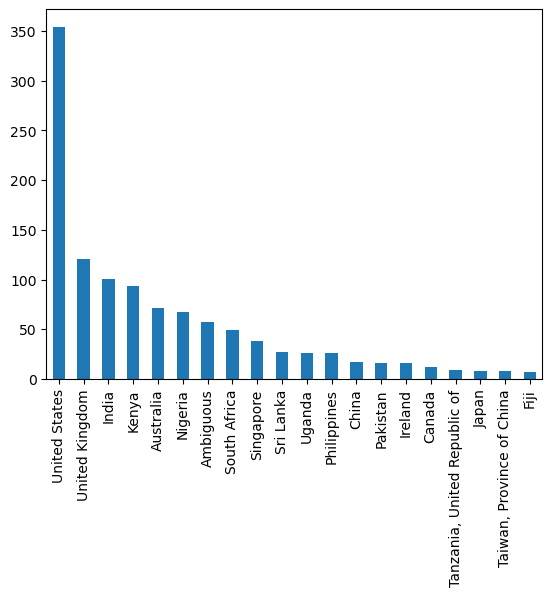

In [25]:
data['Primary_Country'].value_counts()[:20].plot(kind='bar')

<AxesSubplot:>

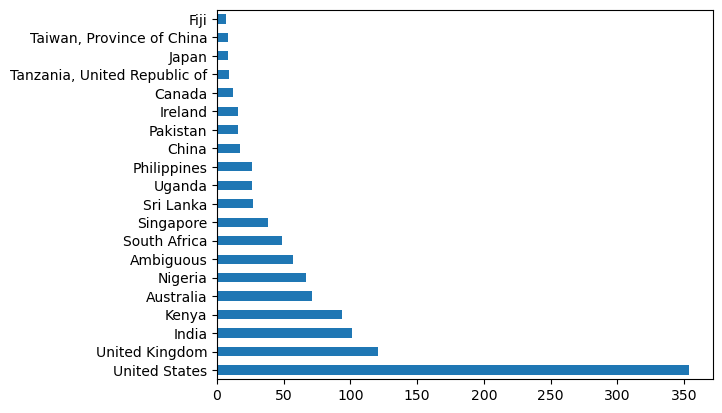

In [26]:
data['Primary_Country'].value_counts()[:20].plot(kind='barh')

In [31]:
data['Motive']

0                       Politics
1                           Fear
2                       Politics
3                           Fear
4                           Fear
                  ...           
1264           Downplay Severity
1265    Undermine target country
1266    Undermine target country
1267                        Fear
1268           Downplay Severity
Name: Motive, Length: 1269, dtype: object

In [41]:
data.head()

,Reported_On,Additional_Reporting,Retrieve_from_1,Retrieve_from_2,Retrieve_from_3,Twitter_Reference,Direct_Post_1,Direct_Post_2,Direct_Post_3,Direct_Post_4,...,Narrative_Description,ChainMsg_or_Email,Motive,Motive_Description,Source,Source_Description,Distrib_Channel,Misinfo_Type,Key_Words,Summary
0,https://www.buzzfeednews.com/article/ryanhates...,,https://www.buzzfeednews.com/article/ryanhates...,,,False,,,,,...,Hindi language YouTube account saying COVID-19...,False,Politics,Efforts to spread false claims on the origins ...,Individual actor,General public,Youtube,Conspiracy,"Coronavirus, India, bat soup",Hindi language Youtube account suggesting COVI...
1,https://twitter.com/Rangoli_A/status/122779241...,,,,,True,https://twitter.com/Rangoli_A/status/122779241...,,,,...,Twitter user posting a compilation video of pe...,False,Fear,"Twitter user stoking fear among other users, s...",Individual actor,General public,Twitter,False reporting,"Coronavirus, China, shooting","Tweet with video showing ""people getting shot ..."
2,https://twitter.com/Woppa1Woppa/status/1220068...,,,,,True,https://twitter.com/Woppa1Woppa/status/1220068...,,,,...,Twitter user posting a video of a celebrity ea...,False,Politics,Twitter user discrediting Chinese-American pop...,Individual actor,General public,Twitter,False reporting,"Coronavirus, Chinese food, bat soup","Video of an individual eating a delicacy, and ..."
3,https://twitter.com/FreddiGoldstein/status/123...,,,,,True,https://twitter.com/FreddiGoldstein/status/123...,,,,...,Chain message of NYPD containment responses.,True,Fear,Chain message spread to stoke fear among Ameri...,Individual actor,General public,Twitter,False reporting,"Coronavirus, NYPD, containment zone",Tweet with a screenshot of chain message sugge...
4,https://www.boomlive.in/health/hoax-alert-vira...,,https://www.boomlive.in/health/hoax-alert-vira...,,,False,,,,,...,Chain message of Indian Health Ministry respon...,True,Fear,Chain message spread to stoke fear among India...,Individual actor,General public,Facebook,False reporting,"Coronavirus, India, travel advisory",WhatsApp chain message circulating among India...


<AxesSubplot:xlabel='Motive', ylabel='Primary_Country'>

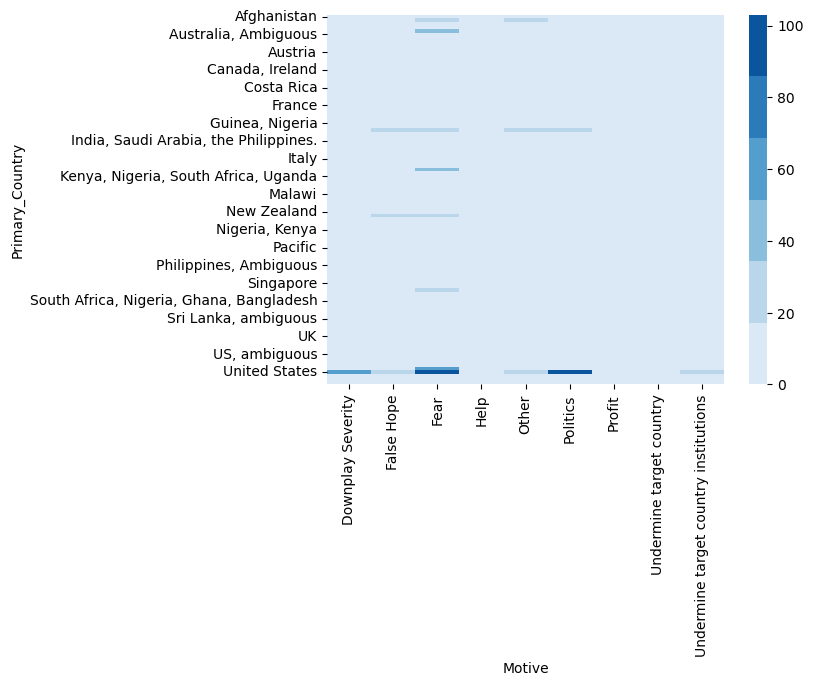

In [43]:
import seaborn as sns
cmap = sns.color_palette("Blues")
sns.heatmap(pd.crosstab(df.Primary_Country, df.Motive), cmap=cmap)

In [50]:
corr_data = df[['Primary_Country','Motive']]
corr_data.apply(lambda x: x.factorize()[0]).corr()


,Primary_Country,Motive
Primary_Country,1.000000,0.005927
Motive,0.005927,1.000000


<AxesSubplot:xlabel='Motive', ylabel='Primary_Country'>

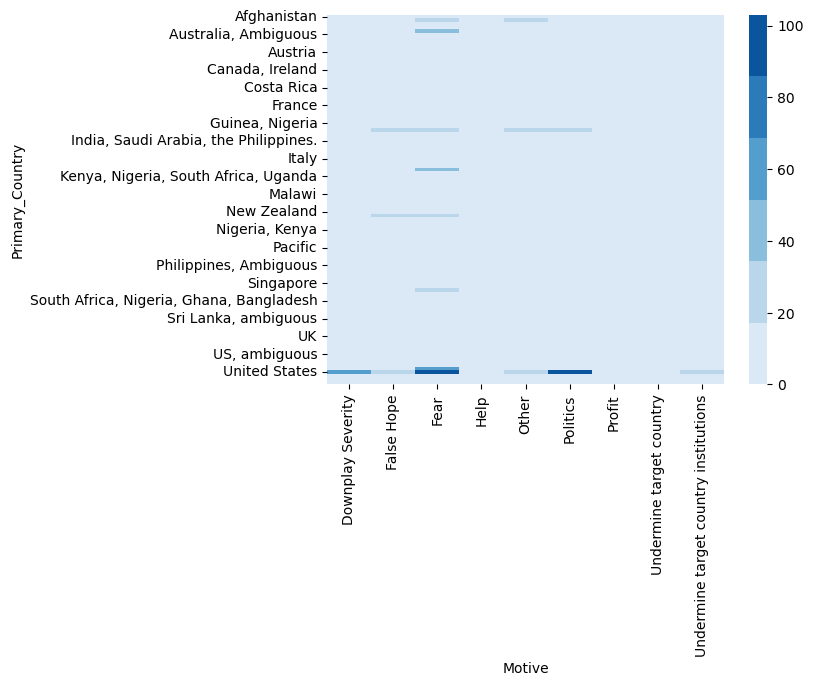

In [51]:

sns.heatmap(pd.crosstab(corr_data.Primary_Country, corr_data.Motive), cmap=cmap)